# Deep Learning Evaluation (Machine Learning TU Vienna 2018)

This notebook is used to evaluate Deep Learning for 2 different datasets:
    1. http://data.vicos.si/datasets/FIDS30/FIDS30.zip
    2. http://l2r.cs.uiuc.edu/~cogcomp/Data/Car/CarData.tar.gz
    
To run this notebook without the requirement of setting up all dependencies you can simply use following docker image:
https://cloud.docker.com/u/freecraver/repository/docker/freecraver/keras

Make sure to place this notebook in a shared folder and pass it as volume to the docker container at creation.
Example command (host path assuming Windows OS): `docker run -it -v //D//your//folder//here:/tf/notebooks -p 8888:8888 --name mlex_group8 freecraver/keras`

For GPU support you may substitute `freecraver/keras` with `tensorflow/tensorflow:latest-gpu-py3-jupyter` and install following modules manually via `pip install`:
* keras
* Pillow _(Image processing)_
* sklearn _(Evaluation, Preprocessing)_
* pandas _(Evaluation)_
* requests _(only if dataset not present)_

You still require an NVIDIA docker driver (https://github.com/NVIDIA/nvidia-docker). As the setup for such can be a cumbersome task, the default uses only CPU. Keep in mind that this leads to a major performance loss. (On a side note the tensorflow gpu image also has twice the size of the cpu one..)

Recommend Min. Resource Requirements (for Docker):
* 6 GB RAM

In [93]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import requests
import zipfile
import tarfile
import io

import os
import glob

import gc

car_dir = 'res/car'
fruit_dir = 'res/fruit'

# create directories if they are not present already
if not os.path.exists(car_dir):
    os.makedirs(car_dir)
if not os.path.exists(fruit_dir):
    os.makedirs(fruit_dir)    

## Fetch datasets

This may take a while for the fruits dataset (450MB)

__NOTE: if you already have the data on your local machine simply copy it into the shared folder to sapre the time required for download. Use the following paths:__  
`res/car/` containing the extracted `CarData` folder  
`res/fruit/` containing the extracted `FIDS30` folder

In [2]:
fruit_url = 'http://data.vicos.si/datasets/FIDS30/FIDS30.zip'
car_url = 'http://l2r.cs.uiuc.edu/~cogcomp/Data/Car/CarData.tar.gz'

car_data_path = os.path.join(car_dir,'CarData')
fruits_data_path = os.path.join(fruit_dir, 'FIDS30')

if os.path.exists(car_data_path):
    print("Using local car data")
else:
    print("Fetching car data...")
    r = requests.get(car_url)
    t = tarfile.open(fileobj=io.BytesIO(r.content))
    t.extractall(path=car_dir)
    t.close()

if os.path.exists(fruits_data_path):
    print("Using local fruits data")
else:
    print("Fetching fruit data...")
    r = requests.get(fruit_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=fruit_dir)

print("Finished fetching datasets")

Using local car data
Using local fruits data
Finished fetching datasets


## Retrieve images

**IMPORTANT NOTE: If your kernel crashes at this point, you may have to increase the amount of alllocated RAM for your docker container**

Also the dataset contains many files that are no common JPEGs (i.e. alpha channel, etc.) -> those images are converted to 3-channel JPEGs, for three images this does not work:
* bananas_51.jpg
* peaches_18.jpg
* tomatoes_38.jpg

Those 3 files are ignored


In [18]:
np.mean([[i.shape[0],i.shape[1]] for i in car_images_train], axis=0)

array([ 40., 100.])

In [20]:
def resize_images(images, identifier, target_height = None, target_width = None):
    """
    used to resize all images to the mean height/width
    note that this is prone to generating distorted images
    better results are expected with methods like pyramid pooling (https://arxiv.org/abs/1406.4729)
    """
    if target_height is None or target_width is None:
        target_size = 200
        mean_shape = np.mean([[i.shape[0],i.shape[1]] for i in images], axis=0)
        max_v = max(mean_shape[0], mean_shape[1])
        # scale by preserving average ratio
        target_height = int(target_size * mean_shape[0]/max_v)
        target_width = int(target_size * mean_shape[1]/max_v)
    
    print("Resizing to {}x{} images".format(target_width, target_height))
    
    for i in range(len(images)):
        if target_height != images[i].shape[0] or target_width != images[i].shape[1]:
            # only resize image if it has not already the correct size
            images[i] = np.array(Image.fromarray(images[i]).resize((target_width, target_height), Image.ANTIALIAS))
        print("Resized {} {} images".format(i+1, identifier), end="\r")
        
    return images

def get_car_images(folder = 'TrainImages'):
    files = glob.glob(os.path.join(car_data_path,folder, '*.pgm'))
    print("Found {} car files".format(len(files)))
    images = []
    image_names = []

    for filename in files:
        image_names.append(os.path.basename(filename))
        with Image.open(filename) as img:
            images.append(np.array(img))
    
    images = np.stack(resize_images(images, 'car', target_width=100, target_height=40), axis=0)
    
    return images, image_names

def get_fruit_images():
    images = []
    image_names = []
    cnt=0
    
    for dirpath, dirnames, filenames in os.walk(fruits_data_path):
        for filename in [f for f in filenames if f.endswith(".jpg")]:
            cnt = cnt+1
            with Image.open(os.path.join(dirpath,filename)) as img:
                if img.format != "JPEG":
                    # we only want 3 channels
                    img = img.convert("RGB")
                np_img = np.array(img)
                if len(np_img.shape) != 3 or np_img.shape[2] != 3:
                    # incorrectly imported/converted RGB file
                    continue
                images.append(np_img)
                image_names.append(os.path.split(dirpath)[-1] + "_" + filename)
                print("Found {} fruit files".format(len(image_names)), end="\r")
                
    images = np.stack(resize_images(images, 'fruit'), axis=0)
    
    return images, image_names
    

car_images, car_img_names = get_car_images()
print("-"*60)
fruit_images, fruit_img_names = get_fruit_images() 

Found 1050 car files
Resizing to 100x40 images
Resizing to 200x156 images


## Check import images

figs_11.jpg


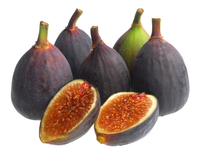

In [21]:
print(fruit_img_names[321])
Image.fromarray(fruit_images[321])

## Ground truth setup

While the goal of the car use case is to predict if a car is present or not (binary), the goal of the fruit dataset is to predict which out of $n$ fruits is present in a picture (n-ary)

In [22]:
cls_car = [0 if name.startswith('neg') else 1 for name in car_img_names]
cls_fruit = [name.split('_')[0] for name in fruit_img_names]

print("{} unique classes for cars".format(len(set(cls_car))))
print("{} unique classes for fruits".format(len(set(cls_fruit))))

2 unique classes for cars
30 unique classes for fruits


## Train/test split

We split the fruits in a stratified fashion (i.e. preserving class label distribution) and load the test data for the car dataset

In [23]:
car_images_train = car_images
cls_car_train = cls_car
car_images_test, car_img_names_t = get_car_images('TestImages')
cls_car_test = [0 if name.startswith('neg') else 1 for name in car_img_names_t]

fruit_images_train, fruit_images_test, cls_fruit_train, cls_fruit_test = train_test_split(fruit_images, cls_fruit, test_size=0.2, random_state=9253, stratify=cls_fruit)

Found 170 car files
Resizing to 100x40 images


## Baseline values

Show how good a dumb classifier that always predicts the most common class is

In [24]:
def print_baseline_stats(cls):
    max_cnt = 0
    for v in set(cls):
        max_cnt = max(max_cnt, cls.count(v))
        print("Class {}: {}".format(v, cls.count(v)))

    print("Baseline accuracy: {}".format(max_cnt/len(cls)))
    
print("-"*20, "\nCar Baseline")
print_baseline_stats(cls_car_train)

print("-"*20, "\nFruits Baseline")
print_baseline_stats(cls_fruit_train)

-------------------- 
Car Baseline
Class 0: 500
Class 1: 550
Baseline accuracy: 0.5238095238095238
-------------------- 
Fruits Baseline
Class cherries: 26
Class avocados: 21
Class blueberries: 26
Class cantaloupes: 25
Class peaches: 21
Class grapefruits: 25
Class pomegranates: 24
Class olives: 18
Class blackberries: 29
Class tomatoes: 36
Class coconuts: 21
Class oranges: 28
Class pineapples: 27
Class guava: 26
Class kiwifruit: 29
Class bananas: 33
Class lemons: 23
Class apricots: 24
Class mangos: 27
Class grapes: 30
Class raspberries: 31
Class figs: 21
Class passionfruit: 18
Class limes: 23
Class apples: 30
Class pears: 26
Class watermelons: 25
Class acerolas: 19
Class strawberries: 37
Class plums: 25
Baseline accuracy: 0.04780361757105943


## Standardization

For the fruits dataset each color-channel is standardized independently, for the car dataset we only have grayscale images (i.e. 1 single channel)

In [25]:
car_scaling = {'mean': car_images_train.mean(), 'std': car_images_train.std()}
fruit_scaling = {'mean': fruit_images_train.mean(axis=(0,1,2), keepdims=True), 
                 'std': fruit_images_train.std(axis=(0,1,2), keepdims=True)}
print(car_scaling)
print(fruit_scaling)

car_images_train = (car_images_train - car_scaling.get('mean')) / car_scaling.get('std')
fruit_images_train = (fruit_images_train - fruit_scaling.get('mean')) / fruit_scaling.get('std')
car_images_test = (car_images_test - car_scaling.get('mean')) / car_scaling.get('std')
fruit_images_test = (fruit_images_test - fruit_scaling.get('mean')) / fruit_scaling.get('std')
print("Car Min-Max", car_images_train.min(),car_images_train.max())
print("Fruit Min-Max", fruit_images_train.min(axis=(0,1,2)), fruit_images_train.max(axis=(0,1,2)))

{'std': 74.27669459504543, 'mean': 129.58246809523808}
{'std': array([[[[74.5967228 , 85.5621107 , 96.07639164]]]]), 'mean': array([[[[181.13993093, 150.25755694, 119.42136967]]]])}
Car Min-Max -1.744591204572555 1.6885179475006928
Fruit Min-Max [-2.42825588 -1.75612261 -1.2429835 ] [0.99012485 1.22416853 1.41115448]


### Adapt shape for Keras model

Convert single channel (grayscale) array to a 4dim array for compliance reasons

In [27]:
car_images_train = car_images_train.reshape(car_images_train.shape[0], car_images_train.shape[1], car_images_train.shape[2], 1)
car_images_test = car_images_test.reshape(car_images_test.shape[0], car_images_test.shape[1], car_images_test.shape[2], 1)
print("Car-Shape", car_images_train.shape)
print("Fruit-Shape", fruit_images_train.shape)

Car-Shape (1050, 40, 100, 1)
Fruit-Shape (774, 156, 200, 3)


## Create the CNN model

We use the same model baseline for both datasets (i.e. the only difference is that the fruits dataset has 3 color channels)

In [30]:
def create_model(input_shape, n_filters =16, kernel_size=3):
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(n_filters, kernel_size, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # ReLu activation
    model.add(MaxPooling2D(pool_size=(2, 2))) # reducing image resolution by half
    model.add(Dropout(0.3))  # random "deletion" of %-portion of units in each batch

    # Layer 2
    model.add(Conv2D(n_filters, kernel_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Flatten()) # Note: Keras does automatic shape inference.
    
    # Full Layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1,activation='sigmoid'))
    
    return model

car_model = create_model(car_images_train.shape[1:])
fruit_model = create_model(fruit_images_train.shape[1:])

### Car model summary

In [31]:
car_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 38, 98, 16)        160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 38, 98, 16)        64        
_________________________________________________________________
activation_7 (Activation)    (None, 38, 98, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 49, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 49, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 47, 16)        2320      
_________________________________________________________________
activation_8 (Activation)    (None, 17, 47, 16)        0         
__________

### Fruit model summary

In [32]:
fruit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 154, 198, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 154, 198, 16)      64        
_________________________________________________________________
activation_10 (Activation)   (None, 154, 198, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 77, 99, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 77, 99, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 97, 16)        2320      
_________________________________________________________________
activation_11 (Activation)   (None, 75, 97, 16)        0         
__________

## Compile models
Defining loss-function, optimizer (e.g. stochastics gradient descent), metrics

In [33]:
car_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
fruit_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Car CNN
From this point on the two models will be handled separately (to save mem usage and for a clearer picture

## Train model

We decided to use 10% of training data as validation data

In [36]:
car_history = car_model.fit(car_images_train, cls_car_train, batch_size=32, epochs=15, validation_split=0.1) 

Train on 945 samples, validate on 105 samples
Epoch 1/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0175 - acc: 0.9947 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 2/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0132 - acc: 0.9968 - val_loss: 0.0206 - val_acc: 0.9810
Epoch 3/15
945/945 [==============================] - 5s 6ms/step - loss: 0.0143 - acc: 0.9926 - val_loss: 0.0174 - val_acc: 0.9905
Epoch 4/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0088 - acc: 0.9989 - val_loss: 0.0175 - val_acc: 0.9905
Epoch 5/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 0.9905
Epoch 6/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0095 - acc: 0.9979 - val_loss: 0.0220 - val_acc: 0.9905
Epoch 7/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0076 - acc: 0.9989 - val_loss: 0.0138 - val_acc: 0.9905
Epoch 8/15
945/945 [==========

## Evaluation on test set

In [37]:
car_pred = car_model.predict_classes(car_images_test)
pd.Series(car_pred.flatten()).value_counts()

In [94]:
accuracy_score(car_pred, cls_car_test)

0.011764705882352941

In [96]:
cls_car_test

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [97]:
car_images_test.shape

(170, 40, 100, 1)

### Plotting training curve

# Results

In [ ]:
car_accuracy_wo_augmentation = 0.011764705882352941

## Helpful utilities

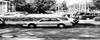

In [100]:
# recreate image be reverting standardization
Image.fromarray((car_images_test[83]*car_scaling.get('std')+car_scaling.get('mean')).astype('uint8').reshape(40,100))